In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from sklearn import model_selection
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

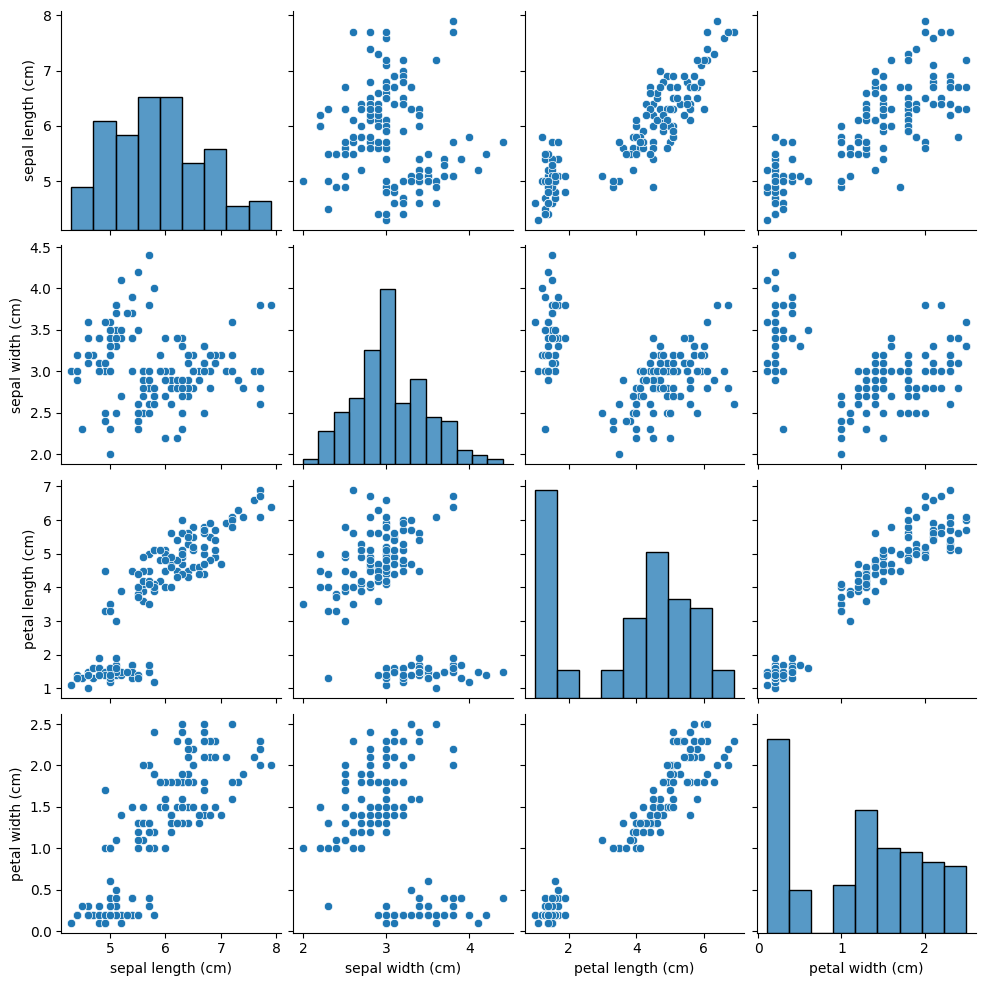

In [3]:
iris_db = datasets.load_iris(as_frame=True)
sn.pairplot(iris_db.data)

In [4]:
iris_db.data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


We will split the data into train and test sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    iris_db.data, # Features or input data or the sepal and petal width and height
    iris_db.target, # Target values or labels or the iris flowers categories: setosa, versicolor, virginica
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()
# print(x_train)

y_train = torch.from_numpy(y_train.values).int()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).int()
y_test = y_test.reshape(-1, 1)

# print(x_train.shape)

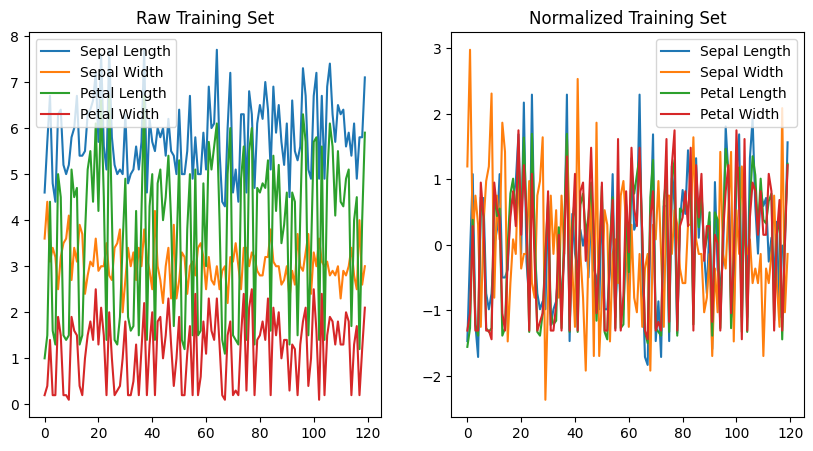

In [6]:
### your code here
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.Tensor:
    z = ((x-mu)/sigma)
    return z

x_train_mu = torch.mean(x_train, dim = 0)
x_train_sigma = torch.std(x_train, dim = 0)

x_train_norm = norm_set(x_train, x_train_mu, x_train_sigma)
x_test_norm = norm_set(x_test, x_train_mu, x_train_sigma)

label_names = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_train)
plt.title('Raw Training Set')
plt.legend(label_names)
plt.subplot(1, 2, 2)
plt.plot(x_train_norm)
plt.title('Normalized Training Set')
plt.legend(label_names)
plt.show()

By inspecting the dataset we see that it contains 4 attributes. (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters). For simplicity we will focus on the first two.

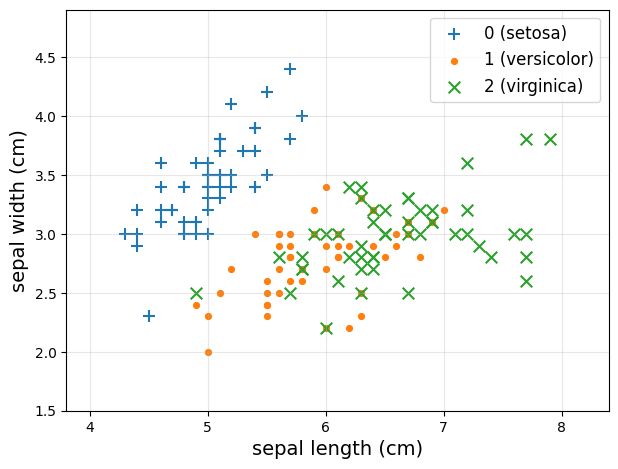

In [7]:
X = iris_db.data.iloc[:, :2] # Populate the variable X with only the first two columns of the iris_db.data as we are considering only them for now
Y = iris_db.target # Target has encoded values for the iris flowers categories: setosa(0), versicolor(1), virginica(2) and we are populating Y with it
marker_list = ['+', '.', 'x'] # To plot the graph
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

for l in [0, 1, 2]:
    ax.scatter(
        X.loc[Y == l].iloc[:, 0], # These lines are used to select the data points (rows) from the dataset X that belong to class l || iloc to select specific columns, in this case, 0
        X.loc[Y == l].iloc[:, 1], # These lines are used to select the data points (rows) from the dataset X that belong to class l || iloc to select specific columns, in this case, 1
        marker=marker_list[l],
        s=70,
        label='{:d} ({:s})'.format(l, iris_db.target_names[l])
        )

ax.legend(fontsize=12)
ax.set_xlabel(iris_db.feature_names[0], fontsize=14)
ax.set_ylabel(iris_db.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X.iloc[:, 0].min() - 0.5, X.iloc[:, 0].max() + 0.5)
ax.set_ylim(X.iloc[:, 1].min() - 0.5, X.iloc[:, 1].max() + 0.5)
plt.show()

Is the data linearly separable?

Here, we are considering the three spece=ies of the Iris Flower: Setosa, Versicolor and Virginica. As can be seen from the above plot, Setosa is linearly separable from Versicolor and Virginica. However, Versicolor and Virginica are not linearly separable from each other.

As there are multiple classes, for now we will focus on class 0 (setosa). As such, we modify the `y_train` and `y_test` tensors, so that each label is 1 if the class is setosa and 0 if otherwise.

In [8]:
train_set_1 = x_train_norm[:, :2] # slice the X training data set by selecting the first 2 columns
test_set_1 = x_test_norm[:, :2] # slice the X testing data set by selecting the first 2 columns

# add a feature for bias
train_set_1 = torch.cat([train_set_1, torch.ones(train_set_1.shape[0], 1)], dim=1) # Add a bias of ones to the train set for the number of elem as there are in the train set. In this case, 120
# train_set_1.shape[0] returns 120
test_set_1 = torch.cat([test_set_1, torch.ones(test_set_1.shape[0], 1)], dim=1) # # Add a bias of ones to the test set for the number of elem as there are in the test set. In this case, 30
# test_set_1.shape[0] returns 30
'''
3 Classes: setosa, versicolor, virginica
For now, we are only considering the setosa class.
So, we are checking here if the classification falls in setosa or other 2 classes.
If the class is setosa, we are encoding it to 1. If the class is any of the other 2, we encode it to 0
'''
setosa_train = (y_train == 0).int() # Does element wise comparison and creates a tensor consisting of 1s and 0s. If the label is setosa, we populate 1 in setosa_train else we populate 0
setosa_test = (y_test == 0).int() # Does element wise comparison and creates a tensor consisting of 1s and 0s. If the label is setosa, we populate 1 in setosa_train else we populate 0

print(test_set_1[0].shape, test_set_1[1].shape, setosa_test.shape)

torch.Size([3]) torch.Size([3]) torch.Size([30, 1])


## 1. Sigmoid function
With logistic regression the values we want to predict are now discrete classes, not continuous variables. In other words, logistic regression is for classification tasks. In the binary classification problem we have classes $0$ and $1$, e.g. classifying email as spam or not spam based on words used in the email.

The logistic/sigmoid function given by the formula below:

$ h_{\theta}(x) = g(\theta^{T}x) =  \frac{1}{1+ e^{-\theta^Tx}} $

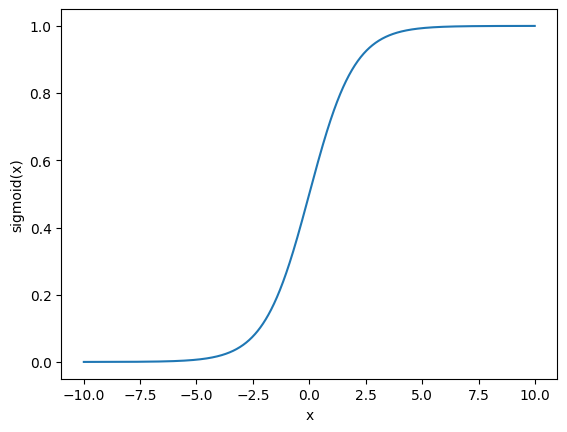

In [9]:
def sigmoid(z: torch.Tensor) -> torch.Tensor:
    # print(z.shape, '\n', z)
  ### your code here
    z = (1/(1+(torch.exp(-z))))
    # print('z:', z)
    return z

'''
Creates a tensor of values ranging from 1 to 1999 with an interval of 1.
'/100' Divides each element of the created tensor by 100 to scale it down by a factor of 100. Converts the range from 1-1999 to 0.01-19.9.
This kind of scaling is often used when you want to represent values in a different unit or precision.
'-10' subtracts 10 from each element of the tensor. This step shifts the range of values from 0.01-19.99 to -9.99 to 9.99 while keeping the shape of the
tensor same
'''
x = torch.arange(1,2000, 1)/100.0 - 10
y = sigmoid(x)
fig, ax1 = plt.subplots()
ax1.plot(x, y)
# set label of horizontal axis
ax1.set_xlabel('x')
# set label of vertical axis
ax1.set_ylabel('sigmoid(x)')
plt.show()

In [10]:
class LogisticRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

  def forward(self, x):
    y = 0
    ### your code here
    y = torch.mm(x, self.weight.t())
    return sigmoid(y)

The cost function we will use for logistic regression is the **Cross Entropy Loss**, which is given by the form:

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ \left(- y^{(i)} log( h_{\theta}(x^{(i)})) - (1-y^{(i)})log(1-h_{\theta}(x^{(i)}))    \right) \right] $

Which when taking partial derivatives and putting these into the gradient descent update equation gives


$
 \theta_{j} =  \theta_{j} - \alpha \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j}
$

In [11]:
def bce(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    m = y_true.shape[0]
    return ((1/m)*(np.sum(-(np.dot(y_true.t(), np.log(y_pred)))-(np.dot((1-y_true).t(), np.log(1-y_pred))))))

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
    weight = model.weight
    N = X.shape[0]
    weight = weight - (lr*(torch.sum(torch.matmul((y_pred-y).t(), X), dim = 0)))
    model.weight = nn.Parameter(weight, requires_grad=False)

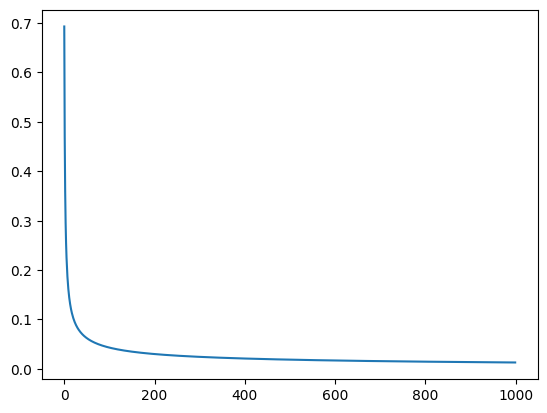

Parameter containing:
tensor([[-8.0550,  4.3156, -4.8374]])
Minimum cost: 0.012939222320534564


In [12]:
def train(model, x, y, alpha):
  cost_lst = list()
  for it in range(1000):
    prediction = model(x)
    cost = bce(y, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x, y, prediction, alpha)
  display.clear_output(wait=True)
  plt.plot(list(range(it+1)), cost_lst)
  plt.show()
  print(model.weight)
  print('Minimum cost: {}'.format(min(cost_lst)))

model = LogisticRegression(train_set_1.shape[1])
alpha = 0.01 # select an appropriate lr
train(model, train_set_1, setosa_train, alpha)

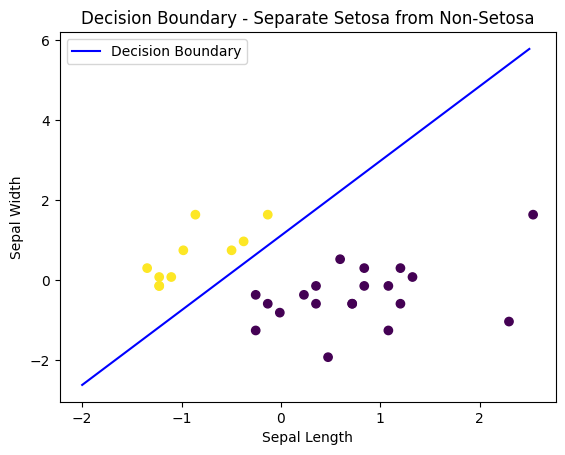

In [13]:
### your code here

d_weight = model.weight.detach().numpy().flatten()

def calc_decision_boundary(x, d_weight):
    return (-(d_weight[0]*x + d_weight[2])/d_weight[1])

x = np.linspace(-2, 2.5, 1000)
y = calc_decision_boundary(x, d_weight)

plt.scatter(test_set_1[:, 0], test_set_1[:, 1], c = setosa_test[:, 0])
plt.plot(x, y, label = 'Decision Boundary', color = 'blue')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend()
plt.title('Decision Boundary - Separate Setosa from Non-Setosa')
plt.show()

## 2. Multiclass
So far, we have focused on a binary classification (is this iris setosa or not), however in this section we will address the problem as a multiclass classification. We will be using a 1 vs. all approach (refer to the lecture notes for details). We will also be using all 4 attributes for the classification.

Firstly, we need to process `y_train, y_test` so that each label is a vector rather than an integer.

In [14]:
y_train = F.one_hot(y_train.reshape(-1).long(), num_classes=3)
y_test = F.one_hot(y_test.reshape(-1).long(), num_classes=3)
# print(y_test)

In this section we will use the built in pytorch methods.


In [15]:
alpha = 0.1
setosa_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
setosa_labels = y_train[:, 0].reshape(-1, 1).float()
setosa_testy = y_test[:, 0].reshape(-1, 1).float()
optimiser = optim.SGD(setosa_model.parameters(), alpha)

def train(model, x, y, test_x, test_y, optimiser, alpha):
  train_lst = list()
  test_lst = list()
  for i in range(1000):
    model.train()
    optimiser.zero_grad()
    pred = model(x)
    cost = F.binary_cross_entropy(pred, y, reduction='mean')
    cost.backward()
    train_lst.append(cost.item())
    optimiser.step()
    model.eval()
    with torch.no_grad():
      test_pred = model(test_x)
      test_cost = F.binary_cross_entropy(test_pred, test_y, reduction='mean')
      test_lst.append(test_cost)
  fig, axs = plt.subplots(2)
  axs[0].plot(list(range(i+1)), train_lst)
  axs[1].plot(list(range(i+1)), test_lst)
  plt.show()
  print('Minimum train cost: {}'.format(min(train_lst)))
  print('Minimum test cost: {}'.format(min(test_lst)))


SETOSA TRAIN


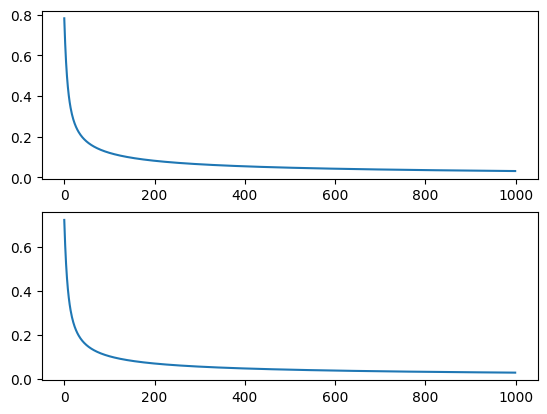

Minimum train cost: 0.031698696315288544
Minimum test cost: 0.027323085814714432


In [16]:
print('SETOSA TRAIN')
train(setosa_model, x_train_norm, setosa_labels, x_test_norm, setosa_testy, optimiser, alpha)

# How does the cost of the 4 attribute model compare to the previous one?
After observing the plots for the 4 attributes model and 2 attributes model, we can see the following:


1. For the model that is trained using only 2 attributes, the rate of training of the model initially decreases rapidly but as the number of model-training iterations increase, the cost of learning converges, but never reaches zero.
3. However, when we increase the number of attibutes from 2 to 4, the model takes more time to train with there being a more gradual decrease in the cost taken to converge to zero.
3. This imples that the model learns faster when there are less attributes to process and the model learns comparatively slower as the number of attributes increase



VERSICOLOR TRAIN


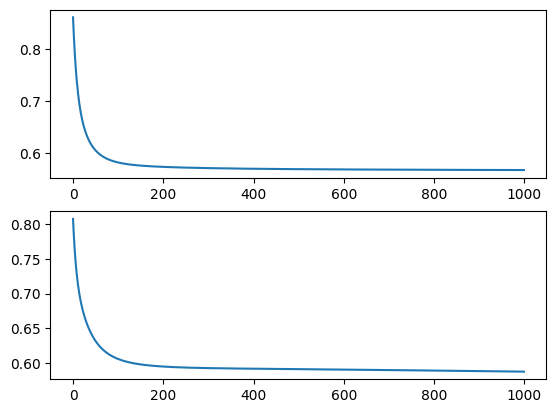

Minimum train cost: 0.5667402744293213
Minimum test cost: 0.5871410965919495


VIRGINICA TRAIN


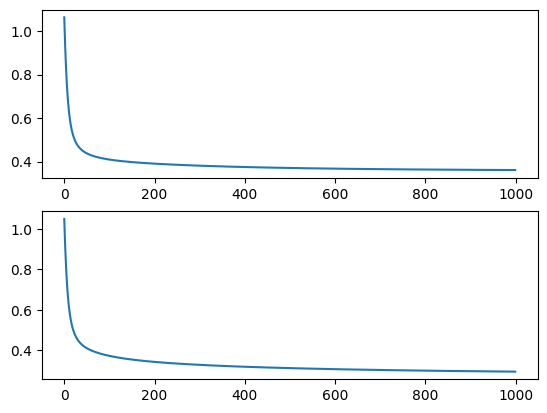

Minimum train cost: 0.3615260720252991
Minimum test cost: 0.2938648760318756


In [17]:
### your code here

versicolor_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
versicolor_labels = y_train[:, 1].reshape(-1, 1).float()
versicolor_testy = y_test[:, 1].reshape(-1, 1).float()
optimiser = optim.SGD(versicolor_model.parameters(), alpha)

print('VERSICOLOR TRAIN')
train(versicolor_model, x_train_norm, versicolor_labels, x_test_norm, versicolor_testy, optimiser, alpha)

virginica_model = nn.Sequential(nn.Linear(x_train.shape[1], 1, bias=False), nn.Sigmoid())
virginica_labels = y_train[:, 2].reshape(-1, 1).float()
virginica_testy = y_test[:, 2].reshape(-1, 1).float()
optimiser = optim.SGD(virginica_model.parameters(), alpha)

print('\n\nVIRGINICA TRAIN')
train(virginica_model, x_train_norm, virginica_labels, x_test_norm, virginica_testy, optimiser, alpha)

In [18]:
### your code here
pred_setosa = setosa_model(x_test_norm).detach()
pred_versi = versicolor_model(x_test_norm).detach()
pred_virgi = virginica_model(x_test_norm).detach()

cumulative_predictions = torch.cat([pred_setosa, pred_versi, pred_virgi], dim=1)

pred_class = np.argmax(cumulative_predictions, axis=1)

encoded_y_test = torch.argmax(y_test, dim = 1)

predictions_df = pd.DataFrame({'Predicted': pred_class.numpy(), 'Actual':encoded_y_test})

# Display the predictions in a table
# print(predictions_df)

In [19]:
accuracy = len(list(filter(lambda x:x == True, torch.argmax(torch.softmax(cumulative_predictions, dim = 1), dim = 1) == encoded_y_test)))/len(y_test)
print('The accuracy of the classification is {}%'.format(accuracy*100))

The accuracy of the classification is 90.0%


## 3. The XOR problem

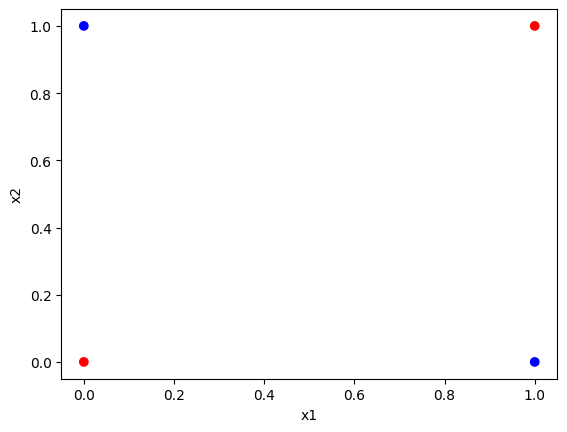

In [20]:
x1 = [0, 0, 1, 1]
x2 = [0, 1, 0, 1]
y = [0, 1, 1, 0]

c_map = ['r', 'b', 'b', 'r']
plt.scatter(x1, x2, c=c_map)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()